In [1]:
!pip install deep_translator
!pip install ezdxf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.6 MB/s eta 0:00:0000:0100:01


In [1]:
# Imports
%matplotlib inline
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from transformers import CLIPTextModel, CLIPTokenizer, CLIPTextModelWithProjection
from diffusers import AutoencoderKL, UNet2DConditionModel, AutoPipelineForText2Image
from diffusers import LMSDiscreteScheduler
from deep_translator import GoogleTranslator
import re
import cv2
import numpy as np
import ezdxf

# device to be used
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Using device cuda:0


In [2]:
def hebrew_translator(user_prompt):
    """
    function for testing whether user's input is in Hebrew or in English - if it's
    in Hebrew then it will translate it to English
    :param user_prompt:
    :return:
    """
    contains_hebrew = re.search(r"[\u0590-\u05FF]", user_prompt) is not None
    if contains_hebrew:
        return GoogleTranslator(source='auto', target='en').translate(user_prompt)
    else:
        prompt_en = user_prompt

    return prompt_en

In [3]:
def add_nikud(text):
    """
    מוסיפה סימנים לוגיים (יוניקוד) לפי בחירת המשתמש:
    ב כ פ – דגש
    ו – חולם / שורוק / רגיל
    י – עם חיריק / בלי
    ש – s או sh
    """

    result = ""

    for ch in text:

        # ב כ פ – דגש
        if ch in ('ב', 'כ', 'פ'):
            ans = input(f"האם האות '{ch}' היא עם דגש? (כן/לא) ").strip().lower()
            result += ch
            if ans == 'כן':
                result += DAGESH

        # ו – חולם / שורוק / רגיל
        elif ch == 'ו':
            ans = input(
                "האם זו ו עם חולם vo / שורוק vu / רגיל v? (חו/ש/ר) "
            ).strip().lower()

            result += ch
            if ans == 'חו':
                result += HOLAM
            elif ans == 'ש':
                result += SHURUK

        # י – חיריק
        elif ch == 'י':
            ans = input("האם זו י עם חיריק yi ? (כן/לא) ").strip().lower()
            result += ch
            if ans == 'כן':
                result += HIRIK

        # ש – s או sh
        elif ch == 'ש':
          ans = input("האם זו שׂ (s)? (כן/לא) ").strip().lower()
          result += ch
          if ans == 'כן':
              result += SHIN_DOT

        # שאר האותיות
        else:
            result += ch

    return result


In [4]:
# Braille
DAGESH = '\u05BC'
HIRIK = '\u05B4'
HOLAM = '\u05B9'
SHURUK = '\u05BB'
SHIN_DOT = '\u05C2'

HEBREW_MAP = {
    'א': '⠁',
    'ב': '⠧',
    'ג': '⠛',
    'ד': '⠙',
    'ה': '⠓',
    'ו': '⠺',   # ו רגילה
    'ז': '⠵',
    'ח': '⠭',
    'ט': '⠞',
    'י': '⠚',
    'כ': '⠡',
    'ל': '⠇',
    'מ': '⠍',
    'נ': '⠝',
    'ס': '⠎',
    'ע': '⠫',
    'פ': '⠋', #f
    'צ': '⠮',
    'ק': '⠟',
    'ר': '⠗',
    'ש': '⠩',  #sh
    'ת': '⠹',
    'ך': '⠡',
    'ם': '⠍',
    'ן': '⠝',
    'ף': '⠋',
    'ץ': '⠮',
}

HEBREW_DAGESH_MAP = {
    'ב': '⠃', #B
    'כ': '⠅', #K
    'פ': '⠏', #P
}

VOWEL_TO_BRAILLE = {
    HOLAM: '⠕', # ו עם חולם
    SHURUK: '⠥', # ו עם שורוק
    HIRIK: '⠊',   # י עם חיריק
}

In [5]:
def letter_to_braille(base, marks):

    # שׁ
    if base == 'ש':
      if SHIN_DOT in marks:
        return '⠱'
      return HEBREW_MAP['ש']

    # ב כ פ עם דגש
    if base in HEBREW_DAGESH_MAP and DAGESH in marks:
        return HEBREW_DAGESH_MAP[base]

    # ו
    if base == 'ו':
        if HOLAM in marks:
            return '⠕'
        if SHURUK in marks:
            return '⠥'
        return HEBREW_MAP['ו']

    # י
    if base == 'י':
        if HIRIK in marks:
            return '⠊'
        return HEBREW_MAP['י']

    # רגיל
    return HEBREW_MAP.get(base, base)


In [6]:
def convert_to_braille(text):
    result = []
    i = 0

    while i < len(text):
        ch = text[i]

        if 'א' <= ch <= 'ת':
            base = ch
            marks = []
            i += 1

            # אוספים סימנים לוגיים
            while i < len(text) and '\u0591' <= text[i] <= '\u05C7':
                marks.append(text[i])
                i += 1

            result.append(letter_to_braille(base, marks))
        else:
            result.append(ch)
            i += 1

    return "".join(result[::-1])

In [7]:
def convert_tensor_to_pil_img(tensor):
    """
    function converts a tensor of size CxHxW in [-1,1] to a PIL image in [0,255]
    :param x (torch.Tensor): input tensor.
    :return image (PIL.Image): output image.
    """
    image = (tensor / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

In [8]:
def img_to_dxf(img_location, dxf_location="output.dxf"):
    # Load image
    img = cv2.imread(img_location, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load image at {img_location}")
        return

    # Threshold and invert: we want white contours on a black background
    # Since the input images have black lines on a white background, we use THRESH_BINARY_INV
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create DXF
    doc = ezdxf.new()
    msp = doc.modelspace()

    # Get image height to flip Y coordinates (DXF (0,0) is bottom-left, Image (0,0) is top-left)
    height = img.shape[0]

    for cnt in contours:
        # Convert contour to (x, y) points and flip Y
        points = [(float(p[0][0]), float(height - p[0][1])) for p in cnt]
        
        if len(points) > 1:
            # Add polyline to DXF. Color 7 is Black/White (standard foreground color)
            msp.add_lwpolyline(points, close=True, dxfattribs={'color': 7})

    doc.saveas(dxf_location)
    print(f"Successfully saved DXF to {dxf_location}")

In [10]:
# general settings of Stable Diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    # GPU → float16
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float16
    ).to(device)

else:
    # CPU → float32
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float32
    ).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

: 

: 

: 

In [12]:
## text to image generator from user's input ##

# desired text prompt
hebrew_prompt  = input(" :בבקשה הכנס/י את התמונה שתרצי/שתרצה בספר")
general_prompt = hebrew_translator(hebrew_prompt)
type  = input(" :בבקשה הכנס/י את הקטגוריה של התמונה (פרי, ירק, מספר, אות)")
type = hebrew_translator(type)
user_prompt = (
    f"A single clean vector icon of {general_prompt}, "
    f"classified as a {type}. "
    "Minimalistic outline, high contrast white background, no shading, no texture, "
    "sharp edges, centered composition, no extra objects, no text, no noise."
)
user_prompt = [user_prompt]

# Generate the image
image = pipe(user_prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


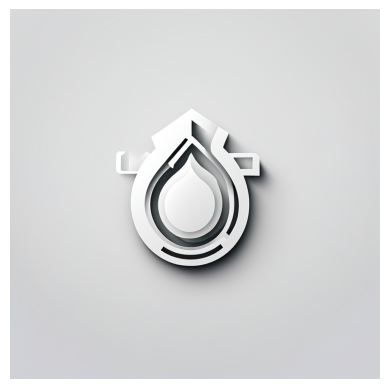

In [13]:
# plot results
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

In [14]:
## Braille converter
hebrew_prompt = add_nikud(hebrew_prompt)
Braille = convert_to_braille(hebrew_prompt)
print(Braille)

In [15]:
!wget -O NotoSansSymbols2-Regular.ttf https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf


--2025-12-24 20:04:44--  https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/notofonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf [following]
--2025-12-24 20:04:44--  https://github.com/notofonts/noto-fonts/raw/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/notofonts/noto-fonts/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf [following]
--2025-12-24 20:04:45--  https://raw.githubusercontent.com/notofonts/noto-fonts/main/hinted/ttf/NotoSansSymbols2/NotoSansSymbols2-Regular.ttf
Resolving raw.githubusercontent.com (raw.git

In [16]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# font_path = "/content/NotoSansSymbols2-Regular.ttf"
font_path = "NotoSansSymbols2-Regular.ttf"

fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Noto Sans Symbols2'

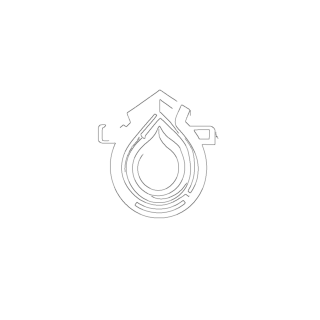

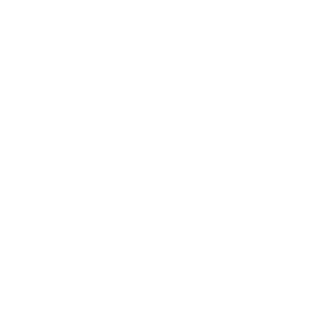

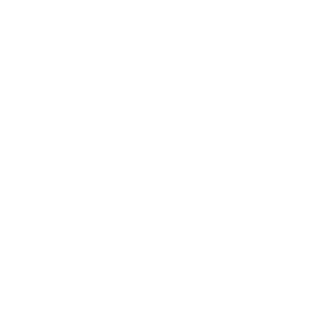

In [17]:
#image processing
image = np.array(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
kernel = np.ones((1, 1), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
edges = cv2.bitwise_not(edges)
h, w = edges.shape
edges[h-1:h, w-1:w] = 255


#centering object
h, w = edges.shape
ys, xs = np.where(edges[1:h-1,1:w-1] == 0)
obj_cx = xs.mean()
obj_cy = ys.mean()
img_cx = w / 2
img_cy = h / 2
shift_x = int(img_cx - obj_cx)
shift_y = int(img_cy - obj_cy)
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
centered = cv2.warpAffine(edges, M, (w, h), borderValue=255)

#plotting final result
# --- 1. Image only ---
plt.figure(figsize=(3.9,3.9))
plt.imshow(centered, cmap="gray")
plt.axis("off")
plt.savefig("image_only.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

# --- 2. Hebrew text only ---
plt.figure(figsize=(3.9,3.9))
plt.text(0.5, 0.9, f'{hebrew_prompt[::-1]}',fontsize=30, color='black', ha='center', va='center', fontweight='light',fontname='DejaVu Sans')
plt.axis("off")
plt.savefig("hebrew.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

# --- 3. Braille text only ---
plt.figure(figsize=(3.9,3.9))
plt.text(0.5, 0.1, f'{Braille}',fontsize=30, color='black', ha='center', va='center', fontweight='light',fontname='Noto Sans Symbols2')
plt.axis("off")
plt.savefig("braille.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()



In [18]:
# Saving as dxf
img_to_dxf("image_only.png", "image_only.dxf")
img_to_dxf("hebrew.png", "hebrew.dxf")
img_to_dxf("braille.png", "braille.dxf")


Successfully saved DXF to image_only.dxf
Successfully saved DXF to hebrew.dxf
Successfully saved DXF to braille.dxf


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 68 (D) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 88 (X) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 70 (F) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 80

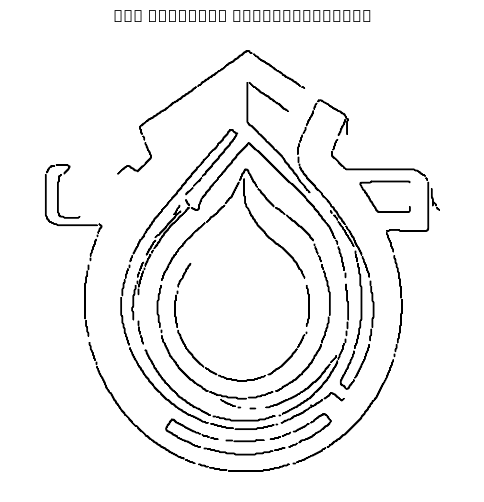

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 104 (h) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 98 (b) missing from font(s) Noto Sans Symbols2.
  fig.canvas.print_figure(bytes_io, **kw)


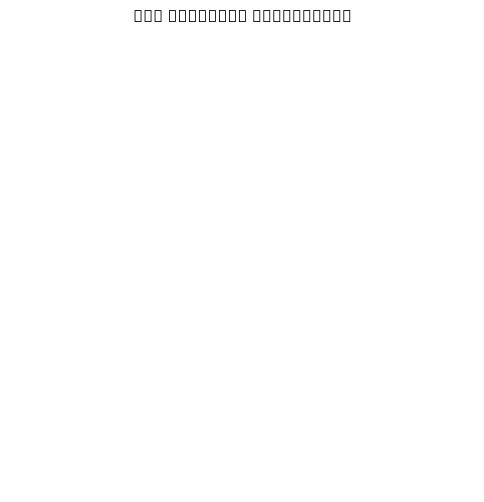

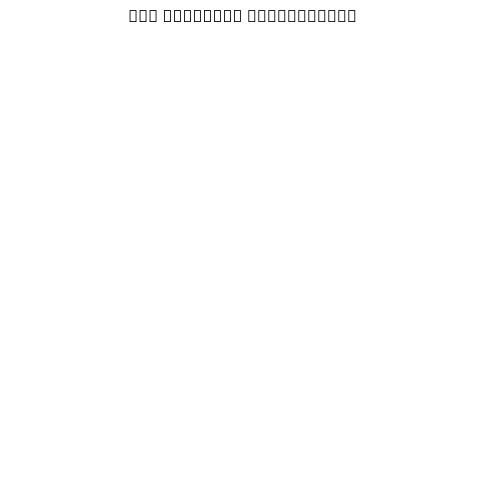

In [19]:
def plot_dxf(dxf_path):
    """
    Helper function to visualize the generated DXF file using Matplotlib.
    """
    try:
        doc = ezdxf.readfile(dxf_path)
        msp = doc.modelspace()
        
        plt.figure(figsize=(6, 6))
        
        # Iterate through entities in modelspace
        for entity in msp:
            if entity.dxftype() == 'LWPOLYLINE':
                # get_points returns format: (x, y, start_width, end_width, bulge)
                points = entity.get_points()
                x = [p[0] for p in points]
                y = [p[1] for p in points]
                
                # Close the shape if the flag is set
                if entity.is_closed:
                    x.append(x[0])
                    y.append(y[0])
                    
                plt.plot(x, y, color='black', linewidth=1)
                
        plt.axis('equal')
        plt.title(f"DXF Preview: {dxf_path}")
        plt.grid(False)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Could not plot DXF: {e}")

# Visualize the results
plot_dxf("image_only.dxf")
plot_dxf("hebrew.dxf")
plot_dxf("braille.dxf")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')